In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('/shared/Wildfire/test_hv_logration_temp/uavsar-wildfire-main/python').resolve()
sys.path.append(str(utils_path))

import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_utils import (preprocess_data,
                           superpixel_segmentation,
                            tv_denoise, 
                            preprocess_for_merge)
from rio_utils import (reproject_arr_to_match_profile)

In [2]:
# Opens a GeoTIFF and loads the backscatter values and profile
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [3]:
def inc_filter(img):
    img_deg = np.rad2deg(img)
    mask = (img_deg < 20) | (img_deg > 60)
    img_deg[mask] = 999
    return img_deg

In [4]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

In [5]:
# import numpy as np
# from scipy.ndimage import generic_filter

# def fill_nan(arr, size=3):
#     """ Helper function to replace NaN with local mean. """
#     arr_filled = np.copy(arr)
#     nan_mask = np.isnan(arr)
    
#     # Only apply the filter to regions that contain NaN
#     if np.any(nan_mask):
#         for i in range(arr.shape[0]):
#             for j in range(arr.shape[1]):
#                 if nan_mask[i, j]:
#                     # Define a small window around the NaN pixel
#                     x_start = max(i - size // 2, 0)
#                     x_end = min(i + size // 2 + 1, arr.shape[0])
#                     y_start = max(j - size // 2, 0)
#                     y_end = min(j + size // 2 + 1, arr.shape[1])
                    
#                     # Get the region and compute the mean ignoring NaNs
#                     region = arr[x_start:x_end, y_start:y_end]
                    
#                     # Check if the region contains any valid (non-NaN) values
#                     if np.any(~np.isnan(region)):
#                         mean_val = np.nanmean(region)
#                     else:
#                         # If no valid values, set to a default value (e.g., 0 or mean of entire array)
#                         mean_val = np.nanmean(arr)  # Or use 0 or another placeholder
#                     arr_filled[i, j] = mean_val
                    
#     return arr_filled

In [6]:


def weighted_inc_merge(img_0, img_1, img_2, img_3, inc_0, inc_1, inc_2, inc_3):
    # Validate pixel values (ensuring they are within the valid range for both images and incidence angles)
    valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 25) & (inc_0 <= 65)
    valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 25) & (inc_1 <= 65)
    valid_pixel_2 = ~np.isnan(img_2) & (inc_2 >= 25) & (inc_2 <= 65)
    valid_pixel_3 = ~np.isnan(img_3) & (inc_3 >= 25) & (inc_3 <= 65)

    # Invalid pixel logic for handling missing or invalid data
    invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 25) | (inc_0 > 65)
    invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 25) | (inc_1 > 65)
    invalid_pixel_2 = np.isnan(img_2) | (inc_2 < 25) | (inc_2 > 65)
    invalid_pixel_3 = np.isnan(img_3) | (inc_3 < 25) | (inc_3 > 65)

    # Weight calculation (ensuring proper weighting per valid pixel)
    total_inc = inc_0 + inc_1 + inc_2 + inc_3
    w0 = np.where(total_inc > 0, inc_0 / total_inc, 0)
    w1 = np.where(total_inc > 0, inc_1 / total_inc, 0)
    w2 = np.where(total_inc > 0, inc_2 / total_inc, 0)
    w3 = np.where(total_inc > 0, inc_3 / total_inc, 0)

    # Prepare the output array
    img_merged = np.empty_like(img_0)
    img_merged[:] = np.nan

    # Combine valid pixels using weighted sum
    img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0] + (w2 * img_2)[valid_pixel_0] + (w3 * img_3)[valid_pixel_0]
    img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1] + (w2 * img_2)[valid_pixel_1] + (w3 * img_3)[valid_pixel_1]
    img_merged[valid_pixel_2] = (w0 * img_0)[valid_pixel_2] + (w1 * img_1)[valid_pixel_2] + (w2 * img_2)[valid_pixel_2] + (w3 * img_3)[valid_pixel_2]
    img_merged[valid_pixel_3] = (w0 * img_0)[valid_pixel_3] + (w1 * img_1)[valid_pixel_3] + (w2 * img_2)[valid_pixel_3] + (w3 * img_3)[valid_pixel_3]

    # Combine cases where one pixel is valid and the others are not
    img_merged[valid_pixel_0 & invalid_pixel_1 & invalid_pixel_2 & invalid_pixel_3] = img_0[valid_pixel_0 & invalid_pixel_1 & invalid_pixel_2 & invalid_pixel_3]
    img_merged[valid_pixel_1 & invalid_pixel_0 & invalid_pixel_2 & invalid_pixel_3] = img_1[valid_pixel_1 & invalid_pixel_0 & invalid_pixel_2 & invalid_pixel_3]
    img_merged[valid_pixel_2 & invalid_pixel_0 & invalid_pixel_1 & invalid_pixel_3] = img_2[valid_pixel_2 & invalid_pixel_0 & invalid_pixel_1 & invalid_pixel_3]
    img_merged[valid_pixel_3 & invalid_pixel_0 & invalid_pixel_1 & invalid_pixel_2] = img_3[valid_pixel_3 & invalid_pixel_0 & invalid_pixel_1 & invalid_pixel_2]

    
    # img_merged = fill_nan(img_merged)
    return img_merged


In [7]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output")
tifs = sorted(list(data_dir.rglob('./*_rtc_box_cropped_45km_40km_perimeter_crop*.tif')))

tifs


[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08525_18076_003_181011_HVHV_rtc_box_cropped_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08525_21065_014_211117_HVHV_rtc_box_cropped_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08527_18001_010_180205_HVHV_rtc_box_cropped_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08527_20029_004_201014_HVHV_rtc_box_cropped_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_26526_18076_002_181011_HVHV_rtc_box_cropped_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_26526_21065_013_2111

In [8]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output")
incs = sorted(list(data_dir.rglob('./*_inc_box_crop_45km_40km_perimeter_crop*.tif')))
incs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08525_18076_003_181011_L090_CX_01_inc_box_crop_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08525_21065_014_211117_L090_CX_01_inc_box_crop_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08527_18001_010_180205_L090_CX_01_inc_box_crop_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_08527_20029_004_201014_L090_CX_01_inc_box_crop_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_26526_18076_002_181011_L090_CX_01_inc_box_crop_45km_40km_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/SanAnd_26526

In [9]:
bands, profiles = zip(*map(open_one, tifs))

bands = list(bands)
for i in range(len(bands)):
    bands[i] = preprocess_for_merge(bands[i]) # mask out the missing data after RTC. Scale the values to ensure consistency

pre_0 = bands[0]
post_0 = bands[1]
pre_1 = bands[2]
post_1 = bands[3]
pre_2 = bands[4]
post_2 = bands[5]
pre_3 = bands[6]
post_3 = bands[7]

profile_pre0 = profiles[0]
profile_post0 = profiles[1]
profile_pre1 = profiles[2]
profile_post1 = profiles[3]
profile_pre2 = profiles[4]
profile_post2 = profiles[5]
profile_pre3 = profiles[6]
profile_post3 = profiles[7]


In [10]:
inc_bands, inc_profiles = zip(*map(open_one, incs))

inc_bands = list(inc_bands)
for i in range(len(inc_bands)):
    inc_bands[i] = inc_filter(inc_bands[i]) # convert angle from radian to degree. Filter out the bad angles

pre_inc_0 = inc_bands[0]
post_inc_0 = inc_bands[1]
pre_inc_1 = inc_bands[2]
post_inc_1 = inc_bands[3]
pre_inc_2 = inc_bands[4]
post_inc_2 = inc_bands[5]
pre_inc_3 = inc_bands[6]
post_inc_3 = inc_bands[7]

profile_pre0_inc = inc_profiles[0]
profile_post0_inc = inc_profiles[1]
profile_pre1_inc = inc_profiles[2]
profile_post1_inc = inc_profiles[3]
profile_pre2_inc = inc_profiles[4]
profile_post2_inc = inc_profiles[5]
profile_pre3_inc = inc_profiles[6]
profile_post3_inc = inc_profiles[7]


In [11]:
resampling = 'bilinear'

In [12]:
# Reproject the original bands to match the profile of pre_0
pre_0, _ = reproject_arr_to_match_profile(pre_0, profile_pre0, profile_pre0, resampling=resampling)
pre_0 = pre_0[0]
post_0, _ = reproject_arr_to_match_profile(post_0, profile_post0, profile_pre0, resampling=resampling)
post_0 = post_0[0]
pre_1, _ = reproject_arr_to_match_profile(pre_1, profile_pre1, profile_pre0, resampling=resampling)
pre_1 = pre_1[0]
post_1, _ = reproject_arr_to_match_profile(post_1, profile_post1, profile_pre0, resampling=resampling)
post_1 = post_1[0]
pre_2, _ = reproject_arr_to_match_profile(pre_2, profile_pre2, profile_pre0, resampling=resampling)
pre_2 = pre_2[0]
post_2, _ = reproject_arr_to_match_profile(post_2, profile_post2, profile_pre0, resampling=resampling)
post_2 = post_2[0]
pre_3, _ = reproject_arr_to_match_profile(pre_3, profile_pre3, profile_pre0, resampling=resampling)
pre_3 = pre_3[0]
post_3, _ = reproject_arr_to_match_profile(post_3, profile_post3, profile_pre0, resampling=resampling)
post_3 = post_3[0]

# Reproject the incidence bands to match the profile of pre_0
pre_inc_0, _ = reproject_arr_to_match_profile(pre_inc_0, profile_pre0_inc, profile_pre0, resampling=resampling)
pre_inc_0 = pre_inc_0[0]
post_inc_0, _ = reproject_arr_to_match_profile(post_inc_0, profile_post0_inc, profile_pre0, resampling=resampling)
post_inc_0 = post_inc_0[0]
pre_inc_1, _ = reproject_arr_to_match_profile(pre_inc_1, profile_pre1_inc, profile_pre0, resampling=resampling)
pre_inc_1 = pre_inc_1[0]
post_inc_1, _ = reproject_arr_to_match_profile(post_inc_1, profile_post1_inc, profile_pre0, resampling=resampling)
post_inc_1 = post_inc_1[0]
pre_inc_2, _ = reproject_arr_to_match_profile(pre_inc_2, profile_pre2_inc, profile_pre0, resampling=resampling)
pre_inc_2 = pre_inc_2[0]
post_inc_2, _ = reproject_arr_to_match_profile(post_inc_2, profile_post2_inc, profile_pre0, resampling=resampling)
post_inc_2 = post_inc_2[0]
pre_inc_3, _ = reproject_arr_to_match_profile(pre_inc_3, profile_pre3_inc, profile_pre0, resampling=resampling)
pre_inc_3 = pre_inc_3[0]
post_inc_3, _ = reproject_arr_to_match_profile(post_inc_3, profile_post3_inc, profile_pre0, resampling=resampling)
post_inc_3 = post_inc_3[0]

# Ensure the arrays match after reprojection, as they are now consistent in shape and profile


In [13]:
# Now you can include pre_2, post_2, pre_inc_2, and post_inc_2 in the merge
hv_0 = weighted_inc_merge(pre_0, pre_1, pre_2, pre_3, pre_inc_0, pre_inc_1, pre_inc_2, pre_inc_3)
hv_1 = weighted_inc_merge(post_0, post_1, post_2, post_3, post_inc_0, post_inc_1, post_inc_2, post_inc_3)


In [14]:
print("hv_0 stats:", np.nanmin(hv_0), np.nanmax(hv_0), np.isnan(hv_0).sum())
print("hv_1 stats:", np.nanmin(hv_1), np.nanmax(hv_1), np.isnan(hv_1).sum())
print("valid log10 mask:", np.sum((hv_0 > 0) & (hv_1 > 0)))


hv_0 stats: 0.001 1.0 21440199
hv_1 stats: 0.001 1.0 21361440
valid log10 mask: 8509508


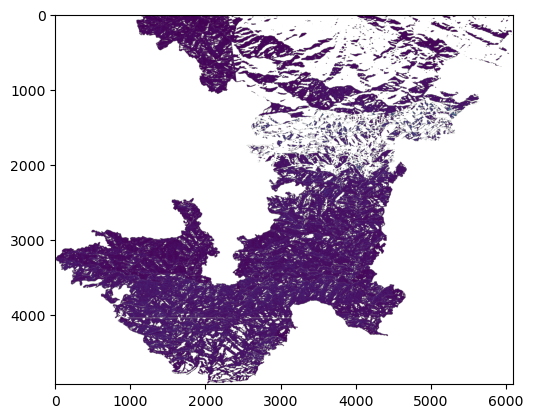

In [15]:
plt.imshow(hv_0)

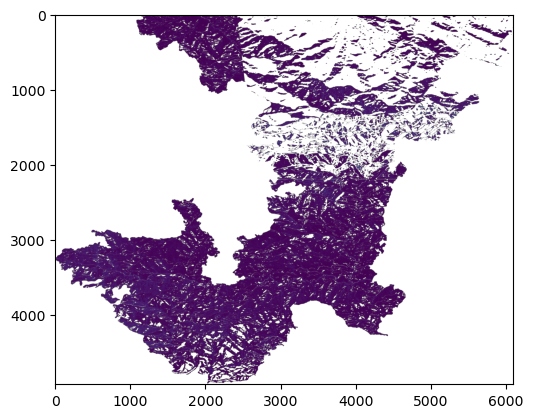

In [16]:
plt.imshow(hv_1)

In [17]:
output_path_0 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/bobcat_hv_0.tif"
output_path_1 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/bobcat_hv_1.tif"

In [18]:
with rasterio.open(output_path_0, "w", **profile_pre0) as dest:
    dest.write(hv_0, 1)
with rasterio.open(output_path_1, "w", **profile_pre0) as dest:
    dest.write(hv_1, 1)

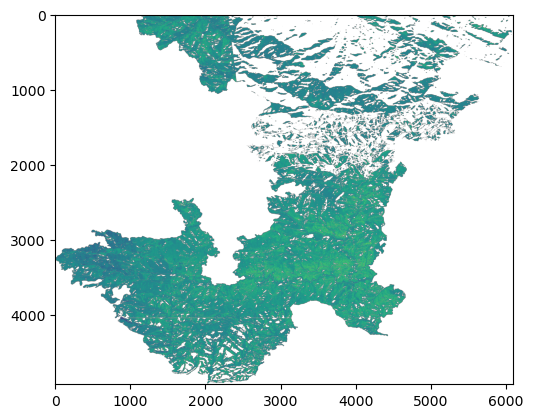

In [19]:
plt.imshow(np.log10(hv_0/hv_1))